### 此文件的作用是： 读取 *.gexf文件，转换为graph形式，提取graph的edge和node矩阵，不同的图的edge和node矩阵以及ged距离组成graph pair，存入到json文件中。
json文件是可直接用于model进行嵌入学习以及训练的文件

In [11]:
import os
import pickle
import numpy as np
import networkx as nx
import regex
import json

from glob import glob
from os.path import basename
from os.path import dirname, abspath, isfile

In [16]:
#root_path =  dirname(dirname(abspath('__file__')))
#print(root_path)
data_path = 'data/LINUX'
train_data_path = os.path.join(data_path, 'train')
test_data_path = os.path.join(data_path, 'test')
""" save_path = os.path.join(root_path, 'save')
result_path = os.path.join(root_path, 'result') """

" save_path = os.path.join(root_path, 'save')\nresult_path = os.path.join(root_path, 'result') "

# 载入LINUX数据
图的形式

In [23]:
def load_graph(datadir):
    
    graphs = []
    path_list=os.listdir(datadir)
    path_list.sort(key=lambda x: int(regex.match('^(\d+)', x).group(1)))
    
    for f in path_list:
        gid = int(basename(f).split('.')[0])
        #print(gid)
        g_path = os.path.join(datadir, f)
        g = nx.read_gexf(g_path)
        g.graph["gid"] = gid
        graphs.append(g)
        if not nx.is_connected(g):  #判断连通性
            raise RuntimeError('{} not connected'.format(gid))

    return graphs

In [49]:
train_graphs = load_graph(train_data_path)
test_graphs = load_graph(test_data_path)
len_train = len(train_graphs)
len_test = len(test_graphs)
print(f'number of train graphs: {len_train}')
print(f'number of test graphs: {len_test}')

number of train graphs: 800
number of test graphs: 200


## 输入一个g, 输出图g的边矩阵、顶点向量

In [57]:
labeled = True

In [53]:
def get_graph_massage(g):
    """
    输入一张图，返回 edges 和 labels
    """
    v = len(g.nodes())
    labels = [1 for i in range(v)]
    
    """重新编号"""
    id = 0
    new_id = {}
    # 建立node 的label和 node的id之间的映射
    for node in g.nodes():
        new_id[node] = id
        id += 1
    
    if labeled == True:
        hsh = list(g.nodes())
        for node in g.nodes().data(): #形如 ('7', {'type': 'C', 'label': '7'})
            # labels[7] = 8
            labels[new_id[node[0]]] = int(node[1]["label"]) + 1
            
    edges = []
    # edges 的每个元素形如： [7, 4]
    for edge in g.edges().data(): #形如 ('7', '4', {'valence': 2, 'id': '6'})
        edges.append([new_id[edge[0]], new_id[edge[1]]])
    # 返回一个图的边矩阵, 以及顶点向量；
    # 这是json的组成形式
    return edges, labels

# 生成json文件

### ged_dict是一个字典， 形式是 [id1, id2] => ged

In [44]:
with open(os.path.join(data_path, 'linux_ged_astar_gidpair_dist_map.pickle'), "rb") as handle:
    ged_dict = pickle.load(handle)

In [46]:
len(ged_dict)

800000

In [47]:
def make_graph_pair(g_1, g_2):
    """
    输入两张图，输出一个dict
    """
    
    graph_1, labels_1 = get_graph_massage(g_1)
    graph_2, labels_2 = get_graph_massage(g_2)
    ged = ged_dict[(g_1.graph["gid"], g_2.graph["gid"])]
    
    ret = {}
    ret["graph_1"] = graph_1
    ret["graph_2"] = graph_2
    ret["labels_1"] = labels_1
    ret["labels_2"] = labels_2
    ret["ged"] = ged
    
    # ret就是每个json文件的组成
    return ret

In [65]:
import json
json_dir = 'dataset/LINUX/json'
try :
    os.makedirs(json_dir)
except:
    pass

train_count = 0
test_count = 0
for i in range(len_train):
    for j in range(i, len_train, 1):
        train_pair = make_graph_pair(train_graphs[i], train_graphs[j])
        json_train_dir = json_dir + '/train'
        try :
            os.makedirs(json_train_dir)
        except:
            pass
        train_pair_path  = json_train_dir + '/{}.json'.format(train_count)
        with open(train_pair_path, 'w') as jf:
            json.dump(train_pair, jf, indent=4)
        train_count = train_count + 1

    for j in range(len_test):
        test_pair = make_graph_pair(test_graphs[j], train_graphs[i])
        json_test_dir = json_dir + '/test'
        try :
            os.makedirs(json_test_dir)
        except:
            pass
        test_pair_path = json_test_dir + '/{}.json'.format(test_count)
        with open(test_pair_path, 'w') as jf_test:
            json.dump(test_pair, jf_test, indent=4)
        test_count = test_count + 1


NameError: name 'json' is not defined

### 读取训练集中的第一张图并画出来

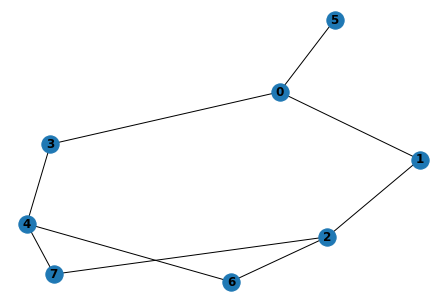

In [27]:
g_1 = train_graphs[0]
nx.draw(g_1, with_labels=True, font_weight='bold')

In [40]:
list(g_1.nodes)

['0', '1', '2', '3', '4', '5', '6', '7']

In [31]:
list(g_1.nodes(data=True))

[('0', {'label': '0'}),
 ('1', {'label': '1'}),
 ('2', {'label': '2'}),
 ('3', {'label': '3'}),
 ('4', {'label': '4'}),
 ('5', {'label': '5'}),
 ('6', {'label': '6'}),
 ('7', {'label': '7'})]

In [42]:
g_1.nodes().data()

NodeDataView({'0': {'label': '0'}, '1': {'label': '1'}, '2': {'label': '2'}, '3': {'label': '3'}, '4': {'label': '4'}, '5': {'label': '5'}, '6': {'label': '6'}, '7': {'label': '7'}})

In [34]:
g_1.edges

EdgeView([('0', '1'), ('0', '3'), ('0', '5'), ('1', '2'), ('2', '6'), ('2', '7'), ('3', '4'), ('4', '6'), ('4', '7')])

In [43]:
g_1.edges.data()

EdgeDataView([('0', '1', {'id': '0'}), ('0', '3', {'id': '1'}), ('0', '5', {'id': '2'}), ('1', '2', {'id': '3'}), ('2', '6', {'id': '4'}), ('2', '7', {'id': '5'}), ('3', '4', {'id': '6'}), ('4', '6', {'id': '7'}), ('4', '7', {'id': '8'})])

In [37]:
[(n, nbrdict) for n, nbrdict in g_1.adjacency()]
# 显示的id是edge的id，即，第几条边
# 总共有9条边，所以显示最大的id为8

[('0', {'1': {'id': '0'}, '3': {'id': '1'}, '5': {'id': '2'}}),
 ('1', {'0': {'id': '0'}, '2': {'id': '3'}}),
 ('2', {'1': {'id': '3'}, '6': {'id': '4'}, '7': {'id': '5'}}),
 ('3', {'0': {'id': '1'}, '4': {'id': '6'}}),
 ('4', {'3': {'id': '6'}, '6': {'id': '7'}, '7': {'id': '8'}}),
 ('5', {'0': {'id': '2'}}),
 ('6', {'2': {'id': '4'}, '4': {'id': '7'}}),
 ('7', {'2': {'id': '5'}, '4': {'id': '8'}})]